In [1]:
import os
from os.path import join
import torch
from torchvision.datasets import ImageNet
from torchvision import transforms
from torchvision.transforms import functional as F
import torch.nn.functional as batch
import torchvision
import torch.nn as nn

from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
from random import random
import torch.multiprocessing as mp
from torch.utils.data import random_split, DataLoader, Subset



In [2]:

# Define the image limit
BATCH_SIZE = 64
TRAIN_SIZE = 120 * BATCH_SIZE
TEST_SIZE = 10 * BATCH_SIZE
LOSS_EVERY = 1
EPOCHS = 1
SPLIT = 'train'
WEIGHT_DECAY=0
LEARNING_RATE = .00005

device = os.environ["DEVICE"]
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils', )

DATA_DIR = os.environ['DATA_PATH']
CACHE_DIR = join(DATA_DIR, 'imagenet_inversion')
RESNET_SIZE = 224

class CachedImageNet(ImageNet):

    def __init__(self, root, split, version='0.1'):
        TRANSFORM = transforms.Compose([
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ])
        super().__init__(root=root, split=split, transform=TRANSFORM)
        self.cache_dir = os.path.join(CACHE_DIR, version, split)

        # Create cache directory if it doesn't exist
        os.makedirs(self.cache_dir, exist_ok=True)
        self.resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
        self.resnet50.eval().to(device)
        self.resnet_layer = self.resnet50.layers[2][0].downsample[0]


    def _get_cache_path(self, index):
        """Get the path for the cached feature."""
        return os.path.join(self.cache_dir, f'feature_{index}.pt')

    def __getitem__(self, index):
        # Load the image and label
        img, object_class = super().__getitem__(index)

        cache_path = self._get_cache_path(index)
        features = None
        if not os.path.exists(cache_path) or random() < .01:
            # Image transformations
            IMGNET_NORM = transforms.Compose([
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
            imgnet_input = F.rgb_to_grayscale(IMGNET_NORM(img), num_output_channels=3).to(device).unsqueeze(0)

            def assign_features(module, input, output):
                nonlocal features
                features = output
            hook = self.resnet_layer.register_forward_hook(assign_features)
            
            with torch.no_grad():
                self.resnet50(imgnet_input)
            hook.remove()
            assert features is not None
            features = features.squeeze(0)
            if os.path.exists(cache_path):
                saved_features = torch.load(cache_path).to(device)
                assert torch.equal(features,saved_features)

            self.save_atomic(features, cache_path)
        else:
            features = torch.load(cache_path).to(device)

        target = F.rgb_to_grayscale(img, num_output_channels=1)
        return features, target
    def save_atomic(self, value, name):
        tmp_name = name + '.tmp' + str(random())
        torch.save(value, tmp_name)
        os.replace(tmp_name, name)
# Example feature extractor: compute mean/std per channel



# Set the start method to 'spawn'
mp.set_start_method('spawn', force=True)
# Initialize CachedImageNet
train_dataset = CachedImageNet(
    root=join(DATA_DIR, 'imagenet'),
    split=SPLIT,
    version='0.9'
)


assert(len(train_dataset) >= TRAIN_SIZE + TEST_SIZE)

# Define the split sizes

# Split the dataset within the limit
train_subset_indices = list(range(TRAIN_SIZE))  # Indices for the training subset
test_subset_indices = list(range(TRAIN_SIZE, TRAIN_SIZE + TEST_SIZE))  # Indices for the test subset

# Create the subsets
train_subset = Subset(train_dataset, train_subset_indices)
test_subset = Subset(train_dataset, test_subset_indices)

# Define the batch size

# Create DataLoaders for train and test
train_loader = DataLoader(
    dataset=train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,  # Shuffle can be enabled based on your training needs
    num_workers=0
)

test_loader = DataLoader(
    dataset=test_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # No need to shuffle test data
    num_workers=0
)

print(f"Train loader contains {len(train_loader)} batches.")
print(f"Test loader contains {len(test_loader)} batches.")


Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


Train loader contains 120 batches.
Test loader contains 10 batches.


torch.Size([64, 1, 224, 224])


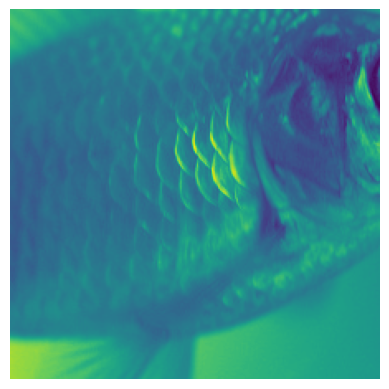

In [3]:
# Get a batch from the DataLoader
def show_image(img_tensor):
    img = img_tensor.cpu().numpy().transpose((1, 2, 0))  # Convert to HWC
    plt.imshow(img)
    plt.axis('off')
    plt.show()


data_iter = iter(train_loader)  # Replace `train_loader` with your DataLoader
features, targets = next(data_iter)
print(targets.shape)
show_image(targets[0])  # Show the first image in the batch

In [4]:
class UpsampleModel(nn.Module):
    def __init__(self):
        super(UpsampleModel, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=1024, out_channels=768,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(768),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(
                in_channels=768, out_channels=512,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(
                in_channels=512, out_channels=384,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(384),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(
                in_channels=384, out_channels=256,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(256, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(32, 16, kernel_size=1, padding=0),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(16, 1, kernel_size=1, padding=0)
        )

    def forward(self, x):
        return self.model(x)



# Example usage:
model = UpsampleModel()


input_tensor = torch.randn(1, 1024, 14, 14)  # Batch size = 1
output_tensor = model(input_tensor)
assert output_tensor.shape == torch.Size([1,1,224,224])

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
params = count_parameters(model)
print("Total parametrs: ", params)
print("Params in samples : ", params / (224*224))

Total parametrs:  24511329
Params in samples :  488.5070352359694


In [5]:
criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

T_max = len(train_loader) * EPOCHS  # Total number of batches across all epochs

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max)

In [6]:
import torch


# Training loop
model.train()
model.to(device)
running_loss = 0.0
losses = []
for epoch in range(EPOCHS):
    for i, (features, target) in enumerate(train_loader):
        features = features.to(device)  # Move to device
        target = target.to(device)

        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, target)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Step the scheduler after each batch
        scheduler.step()

        # Log the running loss
        running_loss += loss.item()
        if i % LOSS_EVERY == LOSS_EVERY - 1:
            avg_loss = running_loss / LOSS_EVERY
            print(f"Epoch {epoch+1}, Batch {i+1}, LR: {scheduler.get_last_lr()[0]:.6f}, Loss: {avg_loss:.4f}")
            losses.append(avg_loss)
            running_loss = 0.0


Epoch 1, Batch 1, LR: 0.000050, Loss: 1.5214


Epoch 1, Batch 2, LR: 0.000050, Loss: 1.3547


Epoch 1, Batch 3, LR: 0.000050, Loss: 1.2591


Epoch 1, Batch 4, LR: 0.000050, Loss: 1.1824


Epoch 1, Batch 5, LR: 0.000050, Loss: 1.1232


Epoch 1, Batch 6, LR: 0.000050, Loss: 1.0522


Epoch 1, Batch 7, LR: 0.000050, Loss: 1.0457


Epoch 1, Batch 8, LR: 0.000049, Loss: 0.9450


Epoch 1, Batch 9, LR: 0.000049, Loss: 0.9300


Epoch 1, Batch 10, LR: 0.000049, Loss: 0.8877


Epoch 1, Batch 11, LR: 0.000049, Loss: 0.9043


Epoch 1, Batch 12, LR: 0.000049, Loss: 0.8686


Epoch 1, Batch 13, LR: 0.000049, Loss: 0.8721


Epoch 1, Batch 14, LR: 0.000048, Loss: 0.8236


Epoch 1, Batch 15, LR: 0.000048, Loss: 0.8086


Epoch 1, Batch 16, LR: 0.000048, Loss: 0.8290


Epoch 1, Batch 17, LR: 0.000048, Loss: 0.8345


Epoch 1, Batch 18, LR: 0.000047, Loss: 0.8153


Epoch 1, Batch 19, LR: 0.000047, Loss: 0.7988


Epoch 1, Batch 20, LR: 0.000047, Loss: 0.7768


Epoch 1, Batch 21, LR: 0.000046, Loss: 0.7603


Epoch 1, Batch 22, LR: 0.000046, Loss: 0.7971


Epoch 1, Batch 23, LR: 0.000046, Loss: 0.7218


Epoch 1, Batch 24, LR: 0.000045, Loss: 0.7331


Epoch 1, Batch 25, LR: 0.000045, Loss: 0.7440


Epoch 1, Batch 26, LR: 0.000044, Loss: 0.7260


Epoch 1, Batch 27, LR: 0.000044, Loss: 0.7576


Epoch 1, Batch 28, LR: 0.000044, Loss: 0.7398


Epoch 1, Batch 29, LR: 0.000043, Loss: 0.7427


Epoch 1, Batch 30, LR: 0.000043, Loss: 0.7205


Epoch 1, Batch 31, LR: 0.000042, Loss: 0.7128


Epoch 1, Batch 32, LR: 0.000042, Loss: 0.7175


Epoch 1, Batch 33, LR: 0.000041, Loss: 0.7167


Epoch 1, Batch 34, LR: 0.000041, Loss: 0.7187


Epoch 1, Batch 35, LR: 0.000040, Loss: 0.6976


Epoch 1, Batch 36, LR: 0.000040, Loss: 0.6750


Epoch 1, Batch 37, LR: 0.000039, Loss: 0.6787


Epoch 1, Batch 38, LR: 0.000039, Loss: 0.7053


Epoch 1, Batch 39, LR: 0.000038, Loss: 0.7190


Epoch 1, Batch 40, LR: 0.000038, Loss: 0.7156


Epoch 1, Batch 41, LR: 0.000037, Loss: 0.7125


Epoch 1, Batch 42, LR: 0.000036, Loss: 0.7005


Epoch 1, Batch 43, LR: 0.000036, Loss: 0.6807


Epoch 1, Batch 44, LR: 0.000035, Loss: 0.6896


Epoch 1, Batch 45, LR: 0.000035, Loss: 0.7093


Epoch 1, Batch 46, LR: 0.000034, Loss: 0.6836


Epoch 1, Batch 47, LR: 0.000033, Loss: 0.6900


Epoch 1, Batch 48, LR: 0.000033, Loss: 0.6897


Epoch 1, Batch 49, LR: 0.000032, Loss: 0.6859


Epoch 1, Batch 50, LR: 0.000031, Loss: 0.7085


Epoch 1, Batch 51, LR: 0.000031, Loss: 0.6809


Epoch 1, Batch 52, LR: 0.000030, Loss: 0.6841


Epoch 1, Batch 53, LR: 0.000030, Loss: 0.7004


Epoch 1, Batch 54, LR: 0.000029, Loss: 0.6831


Epoch 1, Batch 55, LR: 0.000028, Loss: 0.6641


Epoch 1, Batch 56, LR: 0.000028, Loss: 0.6712


Epoch 1, Batch 57, LR: 0.000027, Loss: 0.6862


Epoch 1, Batch 58, LR: 0.000026, Loss: 0.7089


Epoch 1, Batch 59, LR: 0.000026, Loss: 0.7092


Epoch 1, Batch 60, LR: 0.000025, Loss: 0.6945


Epoch 1, Batch 61, LR: 0.000024, Loss: 0.6692


Epoch 1, Batch 62, LR: 0.000024, Loss: 0.6778


Epoch 1, Batch 63, LR: 0.000023, Loss: 0.6822


Epoch 1, Batch 64, LR: 0.000022, Loss: 0.6773


Epoch 1, Batch 65, LR: 0.000022, Loss: 0.6679


Epoch 1, Batch 66, LR: 0.000021, Loss: 0.6734


Epoch 1, Batch 67, LR: 0.000020, Loss: 0.6666


Epoch 1, Batch 68, LR: 0.000020, Loss: 0.6706


Epoch 1, Batch 69, LR: 0.000019, Loss: 0.6742


Epoch 1, Batch 70, LR: 0.000019, Loss: 0.6844


Epoch 1, Batch 71, LR: 0.000018, Loss: 0.6771


Epoch 1, Batch 72, LR: 0.000017, Loss: 0.6613


Epoch 1, Batch 73, LR: 0.000017, Loss: 0.6781


Epoch 1, Batch 74, LR: 0.000016, Loss: 0.6894


Epoch 1, Batch 75, LR: 0.000015, Loss: 0.6611


Epoch 1, Batch 76, LR: 0.000015, Loss: 0.6631


Epoch 1, Batch 77, LR: 0.000014, Loss: 0.6402


Epoch 1, Batch 78, LR: 0.000014, Loss: 0.6818


Epoch 1, Batch 79, LR: 0.000013, Loss: 0.6745


Epoch 1, Batch 80, LR: 0.000013, Loss: 0.6684


Epoch 1, Batch 81, LR: 0.000012, Loss: 0.6635


Epoch 1, Batch 82, LR: 0.000011, Loss: 0.6652


Epoch 1, Batch 83, LR: 0.000011, Loss: 0.6862


Epoch 1, Batch 84, LR: 0.000010, Loss: 0.6762


Epoch 1, Batch 85, LR: 0.000010, Loss: 0.6597


Epoch 1, Batch 86, LR: 0.000009, Loss: 0.6591


Epoch 1, Batch 87, LR: 0.000009, Loss: 0.6541


Epoch 1, Batch 88, LR: 0.000008, Loss: 0.6620


Epoch 1, Batch 89, LR: 0.000008, Loss: 0.6697


Epoch 1, Batch 90, LR: 0.000007, Loss: 0.6662


Epoch 1, Batch 91, LR: 0.000007, Loss: 0.6908


Epoch 1, Batch 92, LR: 0.000006, Loss: 0.6821


Epoch 1, Batch 93, LR: 0.000006, Loss: 0.6661


Epoch 1, Batch 94, LR: 0.000006, Loss: 0.6612


Epoch 1, Batch 95, LR: 0.000005, Loss: 0.6540


Epoch 1, Batch 96, LR: 0.000005, Loss: 0.6694


Epoch 1, Batch 97, LR: 0.000004, Loss: 0.6723


Epoch 1, Batch 98, LR: 0.000004, Loss: 0.6812


Epoch 1, Batch 99, LR: 0.000004, Loss: 0.6714


Epoch 1, Batch 100, LR: 0.000003, Loss: 0.6691


Epoch 1, Batch 101, LR: 0.000003, Loss: 0.6584


Epoch 1, Batch 102, LR: 0.000003, Loss: 0.6604


Epoch 1, Batch 103, LR: 0.000002, Loss: 0.6847


Epoch 1, Batch 104, LR: 0.000002, Loss: 0.6645


Epoch 1, Batch 105, LR: 0.000002, Loss: 0.6538


Epoch 1, Batch 106, LR: 0.000002, Loss: 0.6708


Epoch 1, Batch 107, LR: 0.000001, Loss: 0.6892


Epoch 1, Batch 108, LR: 0.000001, Loss: 0.6869


Epoch 1, Batch 109, LR: 0.000001, Loss: 0.6681


Epoch 1, Batch 110, LR: 0.000001, Loss: 0.6609


Epoch 1, Batch 111, LR: 0.000001, Loss: 0.6599


Epoch 1, Batch 112, LR: 0.000001, Loss: 0.6682


Epoch 1, Batch 113, LR: 0.000000, Loss: 0.6393


Epoch 1, Batch 114, LR: 0.000000, Loss: 0.6629


Epoch 1, Batch 115, LR: 0.000000, Loss: 0.6811


Epoch 1, Batch 116, LR: 0.000000, Loss: 0.6475


Epoch 1, Batch 117, LR: 0.000000, Loss: 0.6677


Epoch 1, Batch 118, LR: 0.000000, Loss: 0.6775


Epoch 1, Batch 119, LR: 0.000000, Loss: 0.6649


Epoch 1, Batch 120, LR: 0.000000, Loss: 0.6639


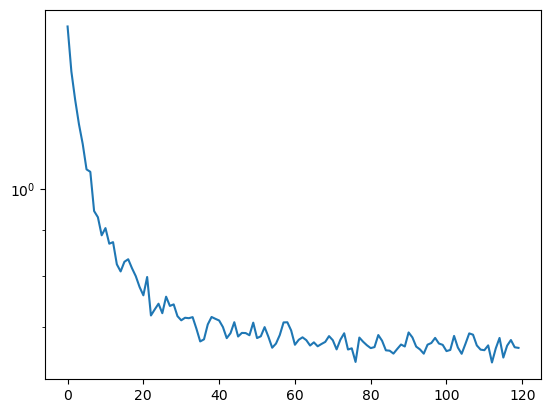

In [7]:
# Plot losses
plt.plot(losses)
plt.yscale('log')
# set maximum y to 

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:01<00:11,  1.26s/it]

 20%|██        | 2/10 [00:02<00:10,  1.32s/it]

 30%|███       | 3/10 [00:03<00:09,  1.31s/it]

 40%|████      | 4/10 [00:05<00:08,  1.48s/it]

 50%|█████     | 5/10 [00:06<00:06,  1.37s/it]

 60%|██████    | 6/10 [00:08<00:05,  1.31s/it]

 70%|███████   | 7/10 [00:09<00:03,  1.25s/it]

 80%|████████  | 8/10 [00:10<00:02,  1.21s/it]

 90%|█████████ | 9/10 [00:11<00:01,  1.20s/it]

100%|██████████| 10/10 [00:12<00:00,  1.18s/it]

100%|██████████| 10/10 [00:12<00:00,  1.26s/it]

Test Loss: 0.6798


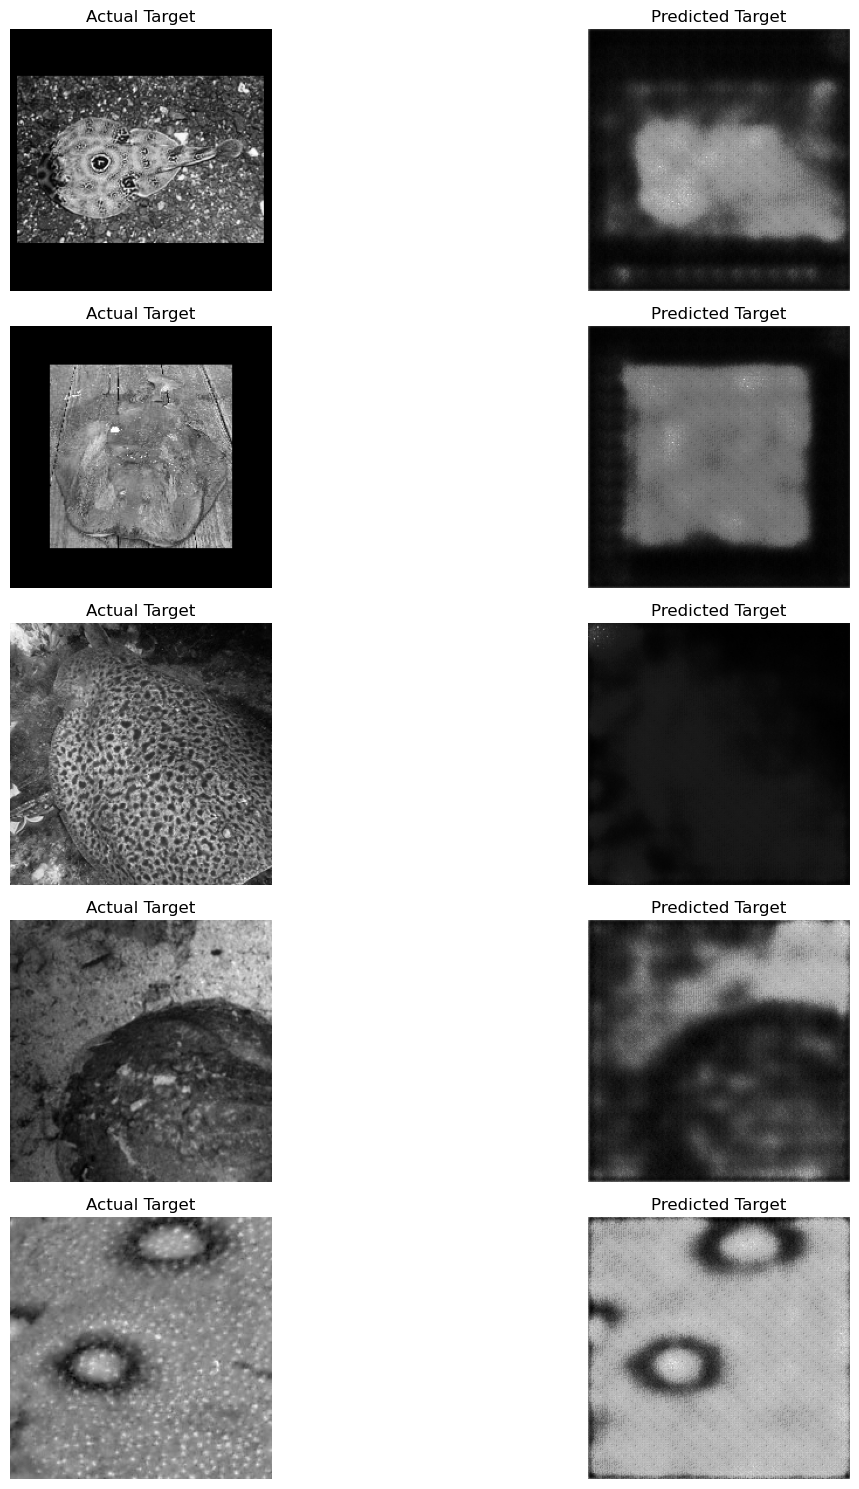

In [8]:
import matplotlib.pyplot as plt

def evaluate_partial_model(model, test_loader, device, max_batches=10_000):
    model.eval()
    test_loss = 0.0
    all_targets = []
    all_predictions = []

    num_batches = min(max_batches, len(test_loader)) 
    processed_batches = 0

    with torch.no_grad():
        for features, target in tqdm(test_loader):
            if processed_batches >= num_batches:
                break

            features = features.to(device)
            target = target.to(device)

            # Predict
            predictions = model(features)

            loss = criterion(predictions, target)
            test_loss += loss.item()

            # Store for plotting
            all_targets.append(target.cpu())
            all_predictions.append(predictions.cpu())

            processed_batches += 1

    test_loss /= processed_batches
    all_targets = torch.cat(all_targets, dim=0)
    all_predictions = torch.cat(all_predictions, dim=0)

    return test_loss, all_targets, all_predictions

# Evaluate on the first 10% of the test dataset
test_loss_partial, partial_targets, partial_predictions = evaluate_partial_model(model, test_loader, device)
print(f"Test Loss: {test_loss_partial:.4f}")

def plot_examples(targets, predictions, num_examples=5):
    plt.figure(figsize=(15, num_examples * 3))
    for i in range(num_examples):
        # Plot the actual target
        plt.subplot(num_examples, 2, 2 * i + 1)
        plt.imshow(targets[i].squeeze(), cmap='gray')  # Squeeze to remove extra dimension
        plt.title("Actual Target")
        plt.axis('off')

        # Plot the predicted target
        plt.subplot(num_examples, 2, 2 * i + 2)
        plt.imshow(predictions[i].squeeze(), cmap='gray')  # Squeeze to remove extra dimension
        plt.title("Predicted Target")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot Examples
num_examples = 5  # Number of examples to visualize
plot_examples(partial_targets[:num_examples].cpu().numpy(), partial_predictions[:num_examples].cpu().numpy())


In [9]:
print(partial_predictions.min(), partial_predictions.max())
print(partial_targets.min(), partial_targets.max())

tensor(-0.7269) tensor(273.9035)
tensor(0.) tensor(0.9999)


In [10]:
name_extra = os.environ['SLURM_JOB_ID'] if 'SLURM_JOB_ID' in os.environ else ''
torch.save(model, join(os.environ['MODELS_PATH'], "mlp" + name_extra + ".pt"))